# NER Results

For Named Entity Recognition, 3 models were built and trained. This notebook explores the results obtained by these models.

The data can be generated using:

<code>python generate_data.py \
	--input_dir data/ \
	--ade_dir ade_corpus/ \
	--target_dir biobert_ner/dataset/ \
	--max_seq_len 128 \
	--dev_split 0.1 \
	--test_split 0.2 \
	--tokenizer biobert-base \
	--ext txt \
	--sep " " \
</code>

1. **Dictionary-based model:** This model does not need to be trained. Run the notebook Dictionary_based_NER.ipynb which would generate a pickle file containing the results for that model.
<br><br>
2. **BiLSTM + CRF model:** To train this model, first change the configurations in *bilstm-crf_ner/model/config.py* and then run *bilstm-crf_ner/train.py* <br> Once training is done, run *bilstm-crf_ner/test.py* to generate the test results.
<br><br>
3. **BioBERT model:** To train the biobert model, change the configurations in *biobert_ner/run_ner.sh* and simply run the file to train the model and generate test results.

In [1]:
import sys
sys.path.append("../")

from seqeval.metrics import classification_report
from seqeval.scheme import IOB2
from utils import open_pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

In [2]:
def read_labels(filename):
    '''
    Reads labels from a file.
    '''
    labels = []
    
    with open(filename, 'r') as f:
        curr_labels = []
        for line in f:
            if line == '\n':
                labels.append(curr_labels)
                curr_labels = []
            elif line:
                curr_labels.append(line.split()[-1])
            else:
                continue
    
    return labels

In [3]:
label_map = {'DRUG': 'Drug', 'STR': 'Strength', 'DUR': 'Duration',
          'ROU': 'Route', 'FOR': 'Form', 'ADE': 'ADE',
          'DOS': 'Dosage', 'REA': 'Reason', 'FRE': 'Frequency'}

In [4]:
# Dictionary based NER
dict_report = open_pickle('../test_data/dict_report.pkl')['strict']

# BioBERT with ADE corpus added
biobert_actual = read_labels('../test_data/biobert_two_ade_test.txt')
biobert_preds = read_labels('../test_data/biobert_two_ade_preds.txt')
biobert_report = classification_report(biobert_actual, biobert_preds, output_dict = True)

# BioBERT without ADE corpus
biobert_no_ade_actual = read_labels('../test_data/biobert_no_ade_test.txt')
biobert_no_ade_preds = read_labels('../test_data/biobert_no_ade_preds.txt')
biobert_no_ade_report = classification_report(biobert_no_ade_actual, biobert_no_ade_preds, output_dict = True)

# BiLSTM + CRF
bilstm_actual = read_labels('../test_data/bilstm_two_ade_test.txt')
bilstm_preds = read_labels('../test_data/bilstm_two_ade_preds.txt')
bilstm_report = classification_report(bilstm_actual, bilstm_preds, output_dict = True)

In [5]:
# Converting short labels to longer labels
for key, val in label_map.items():
    biobert_report[val] = biobert_report.pop(key)
    bilstm_report[val] = bilstm_report.pop(key)

In [6]:
# Creating a dataframe for results
df_list = []
for ent in label_map.values():
    df_list.append((ent, round(dict_report[ent]['f1'], 2), 'Dictionary based'))
    df_list.append((ent, round(bilstm_report[ent]['f1-score'], 2), 'BiLSTM + CRF'))
    df_list.append((ent, round(biobert_report[ent]['f1-score'], 2), 'BioBERT'))
    
pred_df = pd.DataFrame(df_list, columns = ["Entities", "F1 score", "Model"])

## Micro-F1 scores

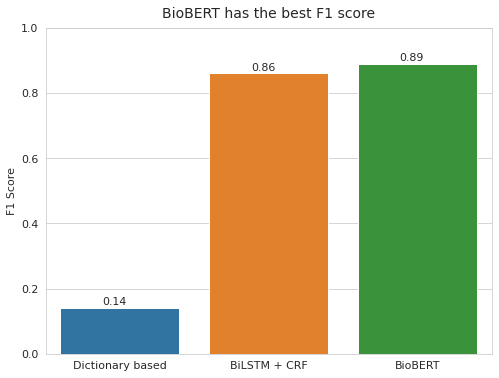

In [9]:
overall_f1 = {"Dictionary based": round(dict_report['micro']['f1'], 2),
              "BiLSTM + CRF": round(bilstm_report['micro avg']['f1-score'], 2),
              "BioBERT": round(biobert_report['micro avg']['f1-score'], 2)}

fig = plt.figure(figsize = (8, 6))
g = sns.barplot(x = list(overall_f1.keys()), y = list(overall_f1.values()))

for i, ent in enumerate([x.get_text() for x in g.get_xticklabels()]):
    g.text(i - 0.12, overall_f1[ent] + 0.01, overall_f1[ent], fontsize = 11)

plt.ylim(0, 1.0)
plt.xlabel("")
plt.ylabel("F1 Score", fontsize = 11)
plt.title("BioBERT has the best F1 score", fontsize = 14, pad = 10)
g.tick_params(axis = 'both', which = 'major', labelsize = 11)


plt.savefig("../plots/ner_micro_f1.jpg", bbox_inches = "tight")
plt.show()

## Micro F1 scores for each entity

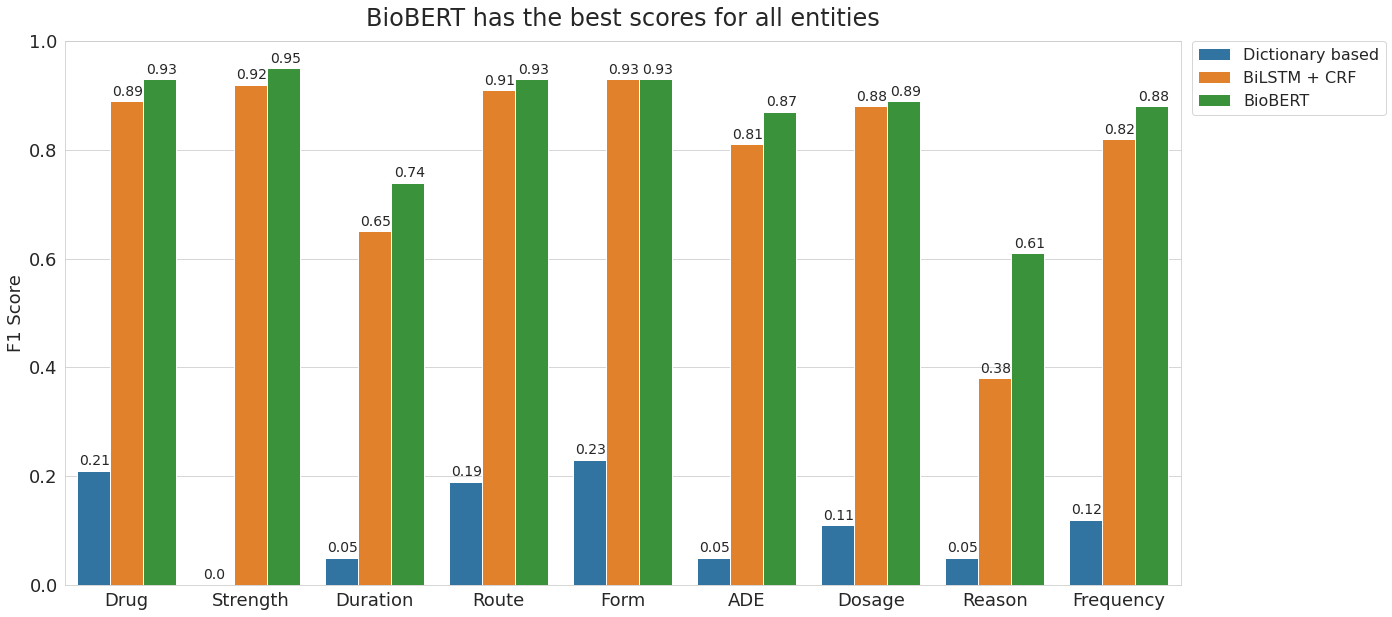

In [7]:
plt.figure(figsize = (20, 10))
g = sns.barplot(x = "Entities", y = "F1 score", hue = "Model", data = pred_df)

for i, ent in enumerate([x.get_text() for x in g.get_xticklabels()]):
    g.text(i - 0.38, round(dict_report[ent]['f1'], 2) + 0.01, 
           round(dict_report[ent]['f1'], 2), fontsize = 14)
    
    g.text(i - 0.12, round(bilstm_report[ent]['f1-score'], 2) + 0.01, 
           round(bilstm_report[ent]['f1-score'], 2), fontsize = 14)
    
    g.text(i + 0.16, round(biobert_report[ent]['f1-score'], 2) + 0.01, 
           round(biobert_report[ent]['f1-score'], 2), fontsize = 14)


plt.ylim(0, 1.0)
plt.xlabel("")
plt.ylabel("F1 Score", fontsize = 18)
plt.title("BioBERT has the best scores for all entities", fontsize = 24, pad = 15)

g.tick_params(axis = 'both', which = 'major', labelsize = 18)

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop = {'size': 16})
plt.savefig("../plots/ner_entity_scores.jpg", bbox_inches = "tight")
plt.show()

## ADE scores with and without training on ADE corpus sample

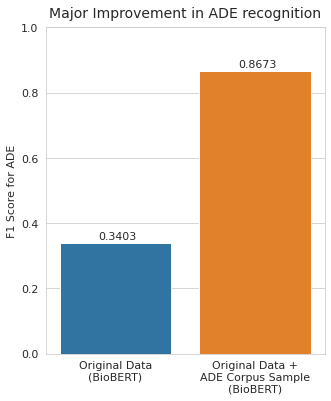

In [10]:
ade_f1 = {'Original Data\n(BioBERT)': round(biobert_no_ade_report['ADE']['f1-score'], 4), 
          'Original Data +\nADE Corpus Sample\n(BioBERT)': round(biobert_report['ADE']['f1-score'], 4)}

fig = plt.figure(figsize = (5, 6))
g = sns.barplot(x = list(ade_f1.keys()), y = list(ade_f1.values()))

for i, ent in enumerate([x.get_text() for x in g.get_xticklabels()]):
    g.text(i - 0.12, ade_f1[ent] + 0.01, ade_f1[ent], fontsize = 11)

plt.ylim(0, 1.0)
plt.xlabel("")
plt.ylabel("F1 Score for ADE", fontsize = 11)
plt.title("Major Improvement in ADE recognition", fontsize = 14, pad = 10)
g.tick_params(axis = 'both', which = 'major', labelsize = 11)


plt.savefig("../plots/ner_ade_f1.jpg", bbox_inches = "tight")
plt.show()

## Score comparision with challenge winners

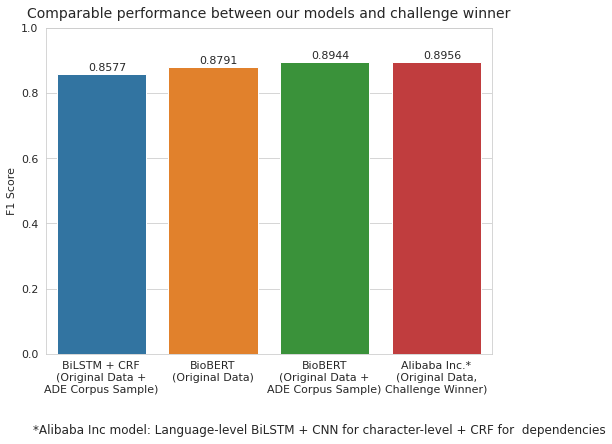

In [8]:
overall_f1 = {"BiLSTM + CRF\n(Original Data +\nADE Corpus Sample)": round(bilstm_report['micro avg']['f1-score'], 4),
              "BioBERT\n(Original Data)": round(biobert_no_ade_report['micro avg']['f1-score'], 4), 
              "BioBERT\n(Original Data +\nADE Corpus Sample)": round(biobert_report['micro avg']['f1-score'], 4), 
              "Alibaba Inc.*\n(Original Data,\nChallenge Winner)": 0.8956}

fig = plt.figure(figsize = (8, 6))
g = sns.barplot(x = list(overall_f1.keys()), y = list(overall_f1.values()))

for i, ent in enumerate([x.get_text() for x in g.get_xticklabels()]):
    g.text(i - 0.12, overall_f1[ent] + 0.01, overall_f1[ent], fontsize = 11)

plt.ylim(0, 1.0)
plt.xlabel("")
plt.ylabel("F1 Score", fontsize = 11)
plt.title("Comparable performance between our models and challenge winner", fontsize = 14, pad = 10)
g.tick_params(axis = 'both', which = 'major', labelsize = 11)

txt = "*Alibaba Inc model: Language-level BiLSTM + CNN for character-level + CRF for  dependencies"
plt.figtext(0.6, -0.06, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig("../plots/ner_micro_f1_challenge.jpg", bbox_inches = "tight")
plt.show()